# XGBoost Model

In [81]:
pip install optuna

In [82]:
import optuna
from openpyxl import workbook
import xgboost as xgb
import pandas as pd   
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_squared_error  
from sklearn.preprocessing import StandardScaler, OneHotEncoder  
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt


## Preprocess

In [83]:
df = pd.read_excel('../test_data_working_students.xlsx')
future_df = df.iloc[4261:]         #incomplete data
df = df.iloc[:4260].dropna()       #this is the complete data

print(df.head())

print(future_df.head())

   Record ID  year  month MoleculeName TradeName ProductName    Packs  \
0          1  2017     12    molecule1    brand1        SKU1   2966.0   
1          2  2017     12    molecule2    brand2        SKU2   7675.0   
2          3  2017     12    molecule2    brand2        SKU3  24404.0   
3          4  2017     12    molecule3    brand3        SKU4  14775.0   
4          5  2017     12    molecule3    brand3        SKU5  18206.0   

          Value  
0  32504.671461  
1   5627.328111  
2  10741.583225  
3  65098.087341  
4  61614.771981  
      Record ID  year  month MoleculeName TradeName ProductName  Packs  Value
4261       4262  2021      1    molecule2    brand2        SKU3    NaN    NaN
4262       4263  2021      1    molecule3    brand3        SKU4    NaN    NaN
4263       4264  2021      1    molecule3    brand3        SKU5    NaN    NaN
4264       4265  2021      1    molecule4    brand4        SKU6    NaN    NaN
4265       4266  2021      1    molecule5    brand6        SKU8

In [84]:
def preprocess(df): 
    df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
    # df['Value_Lag1'] = df.groupby(['MoleculeName', 'TradeName', 'ProductName'])['Value'].shift(1)
    # df['Packs_Lag1'] = df.groupby(['MoleculeName', 'TradeName', 'ProductName'])['Packs'].shift(1)
    df['Value_RollingMean'] = df.groupby(['MoleculeName', 'TradeName', 'ProductName'])['Value'].transform(lambda x: x.rolling(3, min_periods=1).mean())
    df['Packs_RollingMean'] = df.groupby(['MoleculeName', 'TradeName', 'ProductName'])['Packs'].transform(lambda x: x.rolling(3, min_periods=1).mean())

    df['week_of_year'] = df['date'].dt.isocalendar().week.astype(int)   

    return df

df = preprocess(df)
future_df = preprocess(future_df)
print(df.head())
print(future_df.head())

   Record ID  year  month MoleculeName TradeName ProductName    Packs  \
0          1  2017     12    molecule1    brand1        SKU1   2966.0   
1          2  2017     12    molecule2    brand2        SKU2   7675.0   
2          3  2017     12    molecule2    brand2        SKU3  24404.0   
3          4  2017     12    molecule3    brand3        SKU4  14775.0   
4          5  2017     12    molecule3    brand3        SKU5  18206.0   

          Value       date  Value_RollingMean  Packs_RollingMean  week_of_year  
0  32504.671461 2017-12-01       32504.671461             2966.0            48  
1   5627.328111 2017-12-01        5627.328111             7675.0            48  
2  10741.583225 2017-12-01       10741.583225            24404.0            48  
3  65098.087341 2017-12-01       65098.087341            14775.0            48  
4  61614.771981 2017-12-01       61614.771981            18206.0            48  
      Record ID  year  month MoleculeName TradeName ProductName  Packs  Val

## Model

In [86]:
target_value = 'Value'
target_packs = 'Packs'   
features = ['year', 'month', 'week_of_year', 'Value_RollingMean','Packs_RollingMean', 'MoleculeName','TradeName', 'ProductName']

X = df[features]  
y_value = df[target_value]    
y_packs = df[target_packs]  
 

numeric_features = ['year', 'month', 'week_of_year','Value_RollingMean', 'Packs_RollingMean']
categorical_features = ['MoleculeName','TradeName', 'ProductName']    

# scaler = StandardScaler()  
# X_scaled = scaler.fit_transform(X)    
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

pipeline = Pipeline(steps=[('preprocessor', preprocessor)])  
X_processed = pipeline.fit_transform(X)

print(X_processed.shape) 


X_train, X_test, y_train_value, y_test_value = train_test_split(  
    X_processed, y_value, test_size=0.2, random_state=42, shuffle=False)

X_train, X_test, y_train_packs, y_test_packs = train_test_split(
    X_processed, y_packs, test_size=0.2, random_state=42,shuffle=False)  

print(f"Train Shape: {X_train.shape}, Test Shape: {X_test.shape}")

(4254, 254)
Train Shape: (3403, 254), Test Shape: (851, 254)


In [87]:
def obj(trial, X, y): 
    param_grid = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_loguniform('learning_rate',0.01, 0.2),  
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight',1, 10),
        'subsample': trial.suggest_float('subsample', 0.7,1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0)   
    }    
     
    tscv = TimeSeriesSplit(n_splits=5)
    mse_scores = []
    

    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            
        model = xgb.XGBRegressor(**param_grid, objective='reg:squarederror')
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        mse_scores.append(mean_squared_error(y_test, y_pred))
          
    return np.mean(mse_scores)





study_value = optuna.create_study(direction='minimize')   
study_value.optimize(lambda trial: obj(trial, X_processed, y_value), n_trials=50)

study_packs = optuna.create_study(direction='minimize') 
study_packs.optimize(lambda trial: obj(trial, X_processed, y_packs), n_trials=50) 

print("Best params for Value:", study_value.best_params)
print("Best params for Packs:", study_packs.best_params)   

    

[I 2025-03-12 15:02:19,311] A new study created in memory with name: no-name-54d99f30-33b5-46bf-929a-844f810017db
C:\Users\annap\AppData\Local\Temp\ipykernel_20140\1762248702.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate',0.01, 0.2),
[I 2025-03-12 15:02:23,924] Trial 0 finished with value: 7525844814.347522 and parameters: {'n_estimators': 349, 'learning_rate': 0.015550787682440285, 'max_depth': 8, 'min_child_weight': 9, 'subsample': 0.8669599922897425, 'colsample_bytree': 0.8381185434617628}. Best is trial 0 with value: 7525844814.347522.
C:\Users\annap\AppData\Local\Temp\ipykernel_20140\1762248702.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. 

Best params for Value: {'n_estimators': 337, 'learning_rate': 0.01371937564503963, 'max_depth': 4, 'min_child_weight': 4, 'subsample': 0.7300170101435092, 'colsample_bytree': 0.953920500827497}
Best params for Packs: {'n_estimators': 471, 'learning_rate': 0.014700776185588736, 'max_depth': 3, 'min_child_weight': 8, 'subsample': 0.7384030945569402, 'colsample_bytree': 0.9750771140811254}


### Train Model

In [ ]:
best_xgb_value = xgb.XGBRegressor(**study_value.best_params, objective='reg:squarederror')  
best_xgb_packs = xgb.XGBRegressor(**study_packs.best_params, objective='reg:squarederror')  
  
best_xgb_value.fit(X_processed, y_value)  
best_xgb_packs.fit(X_processed, y_packs)  

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9449224820284419,
             enable_categorical=False, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.010504780871260357,
             max_delta_step=0, max_depth=9, min_child_weight=8, missing=nan,
             monotone_constraints='()', n_estimators=384, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.7503366575540322,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
from sklearn.metrics import mean_squared_error

train_preds = best_xgb_value.predict(X_processed)
train_rmse_values = mean_squared_error(y_value, train_preds, squared=False)
print(f"Train RMSE value: {train_rmse_values}")
train_rmse_packs = mean_squared_error(y_packs, train_preds, squared=False)
print(f"Train RMSE packs: {train_rmse_packs}")


Train RMSE value: 70674.066585233
Train RMSE packs: 328091.65885778295


## Predict

In [ ]:
future_df['Value_RollingMean'].fillna(df['Value_RollingMean'].mean(), inplace=True)
future_df['Packs_RollingMean'].fillna(df['Packs_RollingMean'].mean(), inplace=True)

features = ['year', 'month', 'week_of_year', 'MoleculeName', 'TradeName', 'ProductName', 'Value_RollingMean', 'Packs_RollingMean']
future_X = future_df[features].copy()
future_X = future_X.fillna(0)

print(future_X.describe())


# df['Value_Lag1'].fillna(df['Value_Lag1'].mean(), inplace=True)
# df['Packs_Lag1'].fillna(df['Packs_Lag1'].mean(), inplace=True)


# for col in ['Value_Lag1', 'Packs_Lag1']:
#     if col not in future_X.columns:
#         future_X[col] = 0

# future_X = future_X[X.columns]
print(f"Training feature shape: {X.shape}")
print(future_X.head())   

if future_X.empty:
    print("Warning: future_X is empty. Check slicing logic")
else:
    future_X_processed = pipeline.transform(future_X)

    print(f"Future feature shape: {future_X.shape}")

    pred_value = best_xgb_value.predict(future_X_processed)
    pred_pack = best_xgb_packs.predict(future_X_processed)
    future_df['Predicted_Value'] = pred_value
    future_df['Predicted_Packs'] = pred_pack   


print(future_df[['year', 'month', 'Predicted_Value', 'Predicted_Packs']].head())


C:\Users\annap\AppData\Local\Temp\ipykernel_20140\1261541495.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  future_df['Value_RollingMean'].fillna(df['Value_RollingMean'].mean(), inplace=True)
C:\Users\annap\AppData\Local\Temp\ipykernel_20140\1261541495.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting valu

            year         month  week_of_year  Value_RollingMean  \
count  1439231.0  1.439231e+06  1.439231e+06       1.439231e+06   
mean      2021.0  6.023014e+00  2.662678e+01       1.920044e+05   
std          0.0  3.157028e+00  1.443912e+01       3.540999e+05   
min       2021.0  1.000000e+00  5.000000e+00       4.157886e+00   
25%       2021.0  3.000000e+00  1.300000e+01       2.304489e+04   
50%       2021.0  6.000000e+00  2.600000e+01       7.556124e+04   
75%       2021.0  9.000000e+00  3.900000e+01       1.980951e+05   
max       2021.0  1.100000e+01  5.300000e+01       3.343925e+06   

       Packs_RollingMean  
count       1.439231e+06  
mean        3.866525e+04  
std         6.478816e+04  
min         3.000000e+00  
25%         2.989667e+03  
50%         1.296933e+04  
75%         3.977667e+04  
max         3.777137e+05  
Training feature shape: (4254, 8)
   year  month  week_of_year MoleculeName TradeName ProductName  \
0  2021      1            53    molecule2    brand2 

c:\Users\annap\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


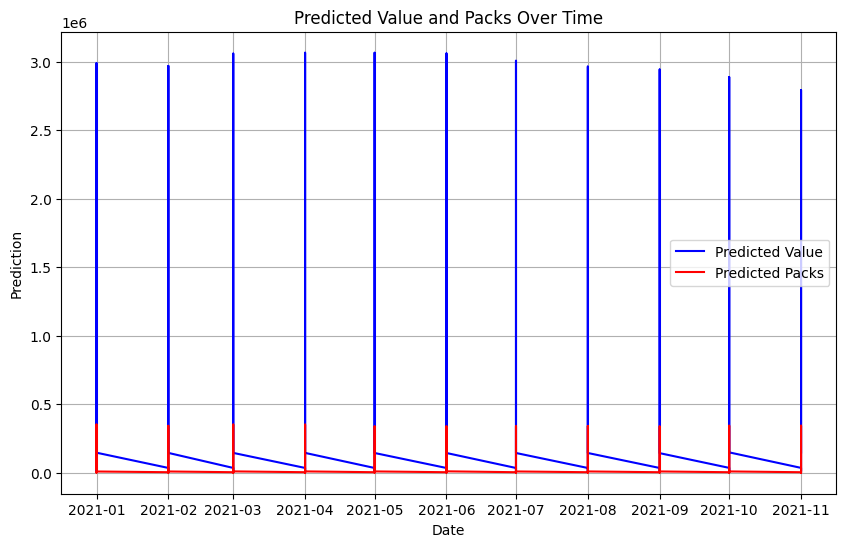

In [101]:
plt.figure(figsize=(10, 6))
plt.plot(future_df['date'], future_df['Predicted_Value'], label='Predicted Value', color='blue')
plt.plot(future_df['date'], future_df['Predicted_Packs'], label='Predicted Packs', color='red')

plt.xlabel('Date')
plt.ylabel('Prediction')
plt.title('Predicted Value and Packs Over Time')
plt.legend()
plt.grid(True)

plt.show()


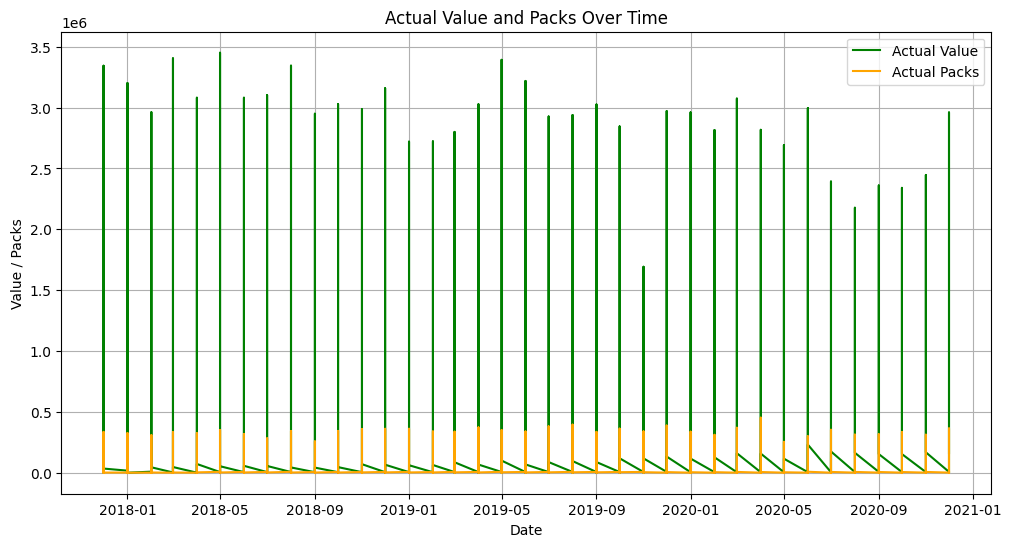

In [93]:

plt.figure(figsize=(12, 6))

plt.plot(df['date'], df['Value'], label='Actual Value', color='green', linestyle='-')
plt.plot(df['date'], df['Packs'], label='Actual Packs', color='orange', linestyle='-')

plt.xlabel('Date')
plt.ylabel('Value / Packs')
plt.title('Actual Value and Packs Over Time')
plt.legend()
plt.grid(True)
plt.show()


In [103]:
import openpyxl

file_path = '../test_data_working_students.xlsx'
wb = openpyxl.load_workbook(file_path)
ws = wb.active  

predicted_values = future_df["Predicted_Value"].tolist()
predicted_packs = future_df["Predicted_Packs"].tolist()

start_row = 4261
col1 = "G"  
col2 = "H" 
max_rows = 1339

# Ensure we only take the allowed number of rows
predicted_values = predicted_values[:max_rows]
predicted_packs = predicted_packs[:max_rows]

# Ensure lengths match
if len(predicted_values) != len(predicted_packs):
    raise ValueError("Mismatch in predicted values and predicted packs lengths!")

# Use correct variable names
for i, (val, pack) in enumerate(zip(predicted_values, predicted_packs), start=start_row):
    if i > 1048576:  # Prevent exceeding row limits
        print(f"Row {i} exceeds Excel's maximum row limit. Stopping.")
        break
    ws[f'G{i}'] = val
    ws[f'H{i}'] = pack

wb.save("forecasted_results.xlsx")
print("Predictions saved to forecasted_results.xlsx")


Predictions saved to forecasted_results.xlsx
